주어진 데이터셋을 차원 축소한 뒤 **다양한 알고리즘**을 적용하여 클러스터링을 진행하고, 결과를 시각화하는 작업을 직접 해보면서 **비지도학습** (Unsupervised Learning)에 대한 이해도를 높여 봅시다.

In [127]:
## 필요한 라이브러리를 임포트합니다.

import pandas as pd
import numpy as np

In [128]:
## 시각화 관련 라이브러리를 임포트합니다.

from matplotlib import pyplot as plt
import seaborn as sns

###데이터

사용할 데이터: 'Marketing Campaign.csv'

주어진 데이터는 마케팅 캠페인을 펼치고자 하는 소비자들에 대한 정보를 나타낸 데이터입니다. 해당 소비자들을 알맞게 군집화시키는 것이 우리의 목적입니다.

총 29개의 column으로 구성되어 있습니다. 



---







데이터에 대한 자세한 설명은 해당 kaggle 페이지에서 확인하실 수 있습니다.

https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign

데이터를 불러옵니다.

In [211]:
## drive에 있는 데이터셋을 불러오기 위해 드라이브와 연동을 합니다.

from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [249]:
## 'Marketing_campaign' 데이터의 위치를 불러와 저장합니다.

data = pd.read_csv('marketing_campaign.csv', \
                   sep = ';')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [250]:
data.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [251]:
data['Dt_Customer']

0       2012-09-04
1       2014-03-08
2       2013-08-21
3       2014-02-10
4       2014-01-19
           ...    
2235    2013-06-13
2236    2014-06-10
2237    2014-01-25
2238    2014-01-24
2239    2012-10-15
Name: Dt_Customer, Length: 2240, dtype: object

### 데이터 전처리

In [252]:
## 등록한 이후에 현재까지의 기간(회원 일수)를 'days'라는 변수로 저장.
from datetime import datetime
y = pd.to_datetime(datetime.today().strftime("%Y-%m-%d")) #datetime 타입으로 변환

data.Dt_Customer = pd.to_datetime(data.Dt_Customer) #datetime 타입으로 변환
data['days'] = y - data.Dt_Customer
data['days'] = data['days'] / np.timedelta64(1, 'D')
data['days'] = data['days'].astype(int) #int형으로 변환
data['days'][:5]

0    3830
1    3280
2    3479
3    3306
4    3328
Name: days, dtype: int32

In [253]:
## 나이를 age에 저장
data['age'] = 2024-data['Year_Birth']

In [254]:
data.iloc[:,20:25]

,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
2235,0,0,0,0,0
2236,0,0,0,1,0
2237,0,1,0,0,0
2238,0,0,0,0,0


In [255]:
## 마케팅 캠페인에서의 총 참여 횟수
data['CampaignAttendance'] = data.iloc[:,20:25].sum(axis=1)

## 이 데이터랑 군집화 결과가 얼마나 유사하게, 또는 다르게 나오는지 비교해봅시다~!!

In [256]:
data['CampaignAttendance']

0       0
1       0
2       0
3       0
4       0
       ..
2235    0
2236    1
2237    1
2238    0
2239    0
Name: CampaignAttendance, Length: 2240, dtype: int64

In [257]:
data.columns

features = ['days', 'age', 'Income', 'Recency', 'MntWines', 'MntFruits',\
                     'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',\
                     'MntGoldProds', 'NumDealsPurchases','NumWebPurchases', \
                     'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',\
                    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',\
                    'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response','CampaignAttendance'] #우리가 고려할 변수들

In [258]:
X_features = data[features]
X_features = X_features.dropna().reset_index(drop = True) #결측치 제거

y_label = X_features['CampaignAttendance'] #캠페인에서의 총 참여 횟수를 임의의 라벨값으로 설정 -> 기준으로 삼아보자.

X_features = X_features.drop(['CampaignAttendance'], axis = 1)

In [259]:
## 각 변수들을 '표준화' scaling 합니다.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_features_scaling  = scaler.fit_transform(X_features)


X_features_scaling = pd.DataFrame(X_features_scaling, columns = X_features.columns, index = list(X_features.index.values))

In [260]:
print(X_features_scaling)

          days       age    Income   Recency  MntWines  MntFruits  \
0     1.529129  0.986443  0.234063  0.310532  0.978226   1.549429   
1    -1.188411  1.236801 -0.234559 -0.380509 -0.872024  -0.637328   
2    -0.205155  0.318822  0.769478 -0.795134  0.358511   0.569159   
3    -1.059945 -1.266777 -1.017239 -0.795134 -0.872024  -0.561922   
4    -0.951244 -1.016420  0.240221  1.554407 -0.391671   0.418348   
...        ...       ...       ...       ...       ...        ...   
2211  0.135772  0.151917  0.356642 -0.104093  1.197646   0.418348   
2212 -1.652863  1.904422  0.467539  0.241428  0.299208  -0.662463   
2213 -0.980889 -1.016420  0.188091  1.450751  1.787710   0.544024   
2214 -0.975948  1.069896  0.675388 -1.417072  0.364441   0.091591   
2215  1.326548  1.236801  0.024705 -0.311405 -0.655568  -0.587058   

      MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  ...  \
0            1.690227         2.454568          1.484827      0.850031  ...   
1           -

In [261]:
#X_features_scaling=X_features_scaling[['days','age']]

###차원 축소

데이터를 차원 축소 해봅시다.

In [262]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## LDA
lda = LinearDiscriminantAnalysis(n_components = 2)
X_train_lda = lda.fit_transform(X_features_scaling, y_label) #차원축소 과정에 y 라벨값을 입력해줌

In [263]:
X_train_lda

array([[ 1.13696746,  1.80485175],
       [-0.3901066 , -0.56287721],
       [-0.49254961, -0.14363735],
       ...,
       [-0.42190691,  2.49365159],
       [-0.35303241,  0.05795945],
       [ 0.42914369,  0.20779748]])

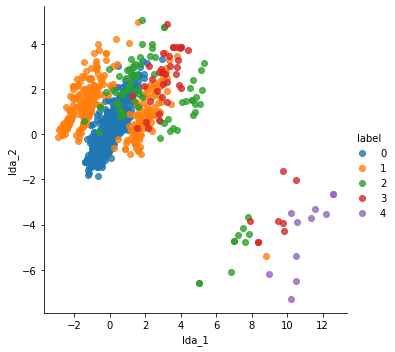

In [264]:
X_train_lda = pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda = pd.concat((X_train_lda, y_label), axis = 1) #X_train_Ida와 y_label 데이터를 하나로 합치기
X_train_lda.columns = ['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x = 'lda_1',y = 'lda_2',data = X_train_lda, hue = 'label', fit_reg = False)
plt.show()

## 우리가 원하는 정답 모양
## 캠페인 참여에서의 총 참여 횟수를 라벨값으로 둔 상태에서의 데이터 분포도

In [265]:
X_train_lda

,lda_1,lda_2,label
0,1.136967,1.804852,0
1,-0.390107,-0.562877,0
2,-0.492550,-0.143637,0
3,-0.353401,-0.644298,0
4,-0.208290,-0.529871,0
...,...,...,...
2211,0.528615,1.351187,0
2212,1.412328,-0.439092,1
2213,-0.421907,2.493652,1
2214,-0.353032,0.057959,0


###K-means Clustering

클러스터링을 돌려 보는 데에 의의가 있기에, 파라미터 값 최적화보다는 각 알고리즘을 사용하면 결과가 어떻게 달라지는 지에 초점을 맞추어 살펴봅니다. 여러 번 시행해보면서 **자유롭게 파라미터를 정해주세요**.

**(직접 최적의 파라미터 값을 찾아서 설정하고 싶으시다면 훨씬 좋습니다! 해당 과제의 모든 코드는 기본 뼈대일 뿐입니다. 코드를 추가 또는 변경하셔도 좋습니다.)**

다른 x값들에 대해서도 캠페인 참여도, 즉 고객의 충실도를 잘 군집화할 수 있을까요? 클러스터링으로 결과를 확인해봅시다.



---





In [286]:
X_features_scaling_=X_features_scaling[['days','age']]

K-means를 이용하여 클러스터링 해봅시다.

In [266]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import KMeans

In [287]:
## 클러스터 수는 5로 설정하고, KMeans를 활용하여 예측된 y값을 만들어 봅시다.

km = KMeans(n_clusters = 5)

y_km = km.fit_predict(X_features_scaling)
y_km

array([1, 2, 1, ..., 3, 1, 2])

In [288]:
X_train_lda['K_means'] = y_km

####시각화

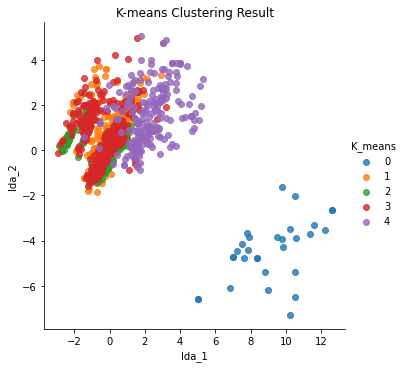

In [289]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'K_means', fit_reg = False)
plt.title('K-means Clustering Result')
plt.show()

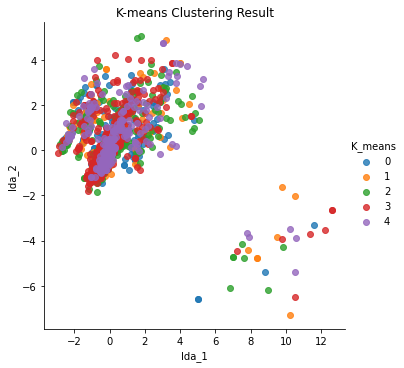

In [291]:
## 클러스터 수는 5로 설정하고, KMeans를 활용하여 예측된 y값을 만들어 봅시다.

km = KMeans(n_clusters = 5)

y_km = km.fit_predict(X_features_scaling_)
y_km
X_train_lda['K_means'] = y_km
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'K_means', fit_reg = False)
plt.title('K-means Clustering Result')
plt.show()

###Hierarchical Clustering

Agglomerative 방법을 이용하여 클러스터링 해봅시다.

In [270]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import AgglomerativeClustering

In [292]:
## 클러스터 수는 5 설정하고, Agglomerative를 활용하여 예측된 y값을 만들어 봅시다.

agghc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward') #와드연결법을 사용합니다.

y_agghc = agghc.fit_predict(X_features_scaling)
y_agghc

array([2, 3, 2, ..., 1, 2, 1], dtype=int64)

In [293]:
X_train_lda['hierarchical'] = y_agghc

####시각화

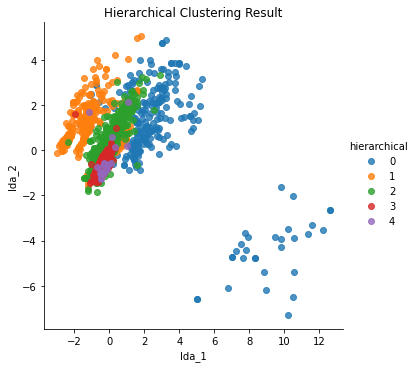

In [294]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'hierarchical', fit_reg = False)
plt.title('Hierarchical Clustering Result')
plt.show()

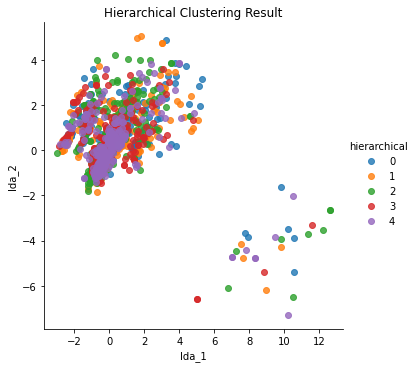

In [295]:
## 클러스터 수는 5 설정하고, Agglomerative를 활용하여 예측된 y값을 만들어 봅시다.

agghc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward') #와드연결법을 사용합니다.

y_agghc = agghc.fit_predict(X_features_scaling_)
y_agghc
X_train_lda['hierarchical'] = y_agghc

sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'hierarchical', fit_reg = False)
plt.title('Hierarchical Clustering Result')
plt.show()

###DBSCAN

DBSCAN을 이용하여 클러스터링 해봅시다.

In [274]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import DBSCAN

In [275]:
X_features_scaling

,days,age,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,1.529129,0.986443,0.234063,0.310532,0.978226,1.549429,1.690227,2.454568,1.484827,0.850031,...,0.693232,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,2.377952
1,-1.188411,1.236801,-0.234559,-0.380509,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,-0.732867,...,-0.131574,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
2,-0.205155,0.318822,0.769478,-0.795134,0.358511,0.569159,-0.178368,1.340203,-0.146821,-0.037937,...,-0.543978,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
3,-1.059945,-1.266777,-1.017239,-0.795134,-0.872024,-0.561922,-0.655551,-0.504892,-0.585174,-0.752171,...,0.280829,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
4,-0.951244,-1.016420,0.240221,1.554407,-0.391671,0.418348,-0.218505,0.152766,-0.000703,-0.559135,...,-0.131574,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,0.135772,0.151917,0.356642,-0.104093,1.197646,0.418348,0.066913,0.079693,2.215416,3.919308,...,-0.131574,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
2212,-1.652863,1.904422,0.467539,0.241428,0.299208,-0.662463,-0.610954,-0.687574,-0.658233,-0.694260,...,0.693232,-0.281773,-0.282705,-0.280839,3.821732,-0.117148,-0.097812,0.0,0.0,-0.420530
2213,-0.980889,-1.016420,0.188091,1.450751,1.787710,0.544024,0.223001,-0.102990,-0.365998,-0.385402,...,0.280829,-0.281773,3.537258,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
2214,-0.975948,1.069896,0.675388,-1.417072,0.364441,0.091591,0.209622,0.773887,0.072356,0.328832,...,-0.956381,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530


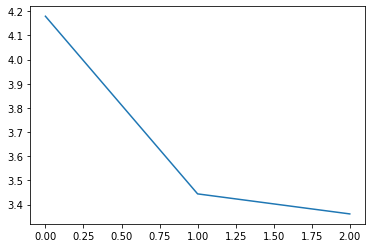

In [302]:
plt.plot(list(range(0,3)), distance[0:3])

In [339]:
## eps는 0.15, minPts는 4로 설정한 뒤 DBSCAN를 활용하여 예측된 y값을 만들어 봅시다.

dbscan = DBSCAN(eps = 0.15, min_samples = 4, metric = 'euclidean') #eps는 0-1

y_dbscan = dbscan.fit(X_features_scaling_)
y_dbscan

DBSCAN(eps=0.15, min_samples=4)

In [340]:
## DBSCAN 결과 나온 라벨 값을 데이터에 저장합니다.
X_features_scaling['Cluster'] = dbscan.labels_

## 어떠한 클러스터가 생성되었는지 살펴봅시다.
X_features_scaling['Cluster']

0       0
1       0
2       0
3       0
4       0
       ..
2211    0
2212    6
2213    0
2214    0
2215    0
Name: Cluster, Length: 2216, dtype: int64

In [342]:
X_train_lda['dbscan'] = y_dbscan
cluster_db = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
print(cluster_db)

7


####시각화

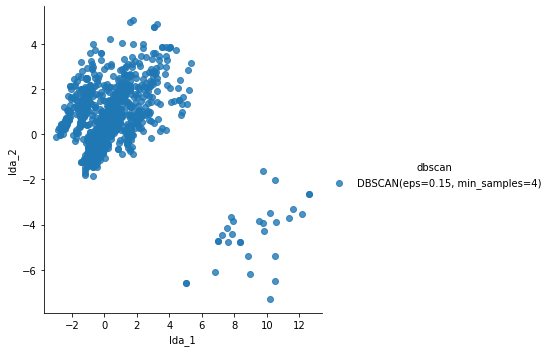

In [343]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'dbscan', fit_reg = False)
plt.show()

###Validation

실루엣 계수를 사용하여 각 클러스터링의 성능을 평가해봅시다.



---



(Q) 실루엣 계수로 평가하기 전에, 육안 상으로 어떠한 알고리즘의 성능이 제일 높아 보이며 어떠한 알고리즘의 성능이 제일 낮아 보이는지 의견을 적어주세요.

성능 높아보임:hierarchical Clustering
성능 낮아보임:DBSCAN



---



이제 실루엣 계수로 성능을 평가해 봅시다!

In [282]:
## 필요한 라이브러리를 임포트합니다.

import sklearn.metrics as metrics
from sklearn.metrics.cluster import silhouette_score

K-means Clustering의 실루엣 계수입니다.

In [347]:
coef_km = metrics.silhouette_score(X_features_scaling_, y_km)
print('Silhouette score is {}.'.format(coef_km))

Silhouette score is 0.3694933195481382.


Hierarchical Clustering의 실루엣 계수입니다.

In [348]:
## Hierarchical Clustering

coef_hc = metrics.silhouette_score(X_features_scaling_, y_agghc)
print('Silhouette score is {}.'.format(coef_hc))

Silhouette score is 0.3255717519587506.


DBSCAN의 실루엣 계수입니다.

In [349]:
## DBSCAN

coef_db = metrics.silhouette_score(X_features_scaling_, dbscan.labels_)
print('Silhouette score is {}.'.format(coef_db))

Silhouette score is -0.19672316484760222.


(Q) 실루엣 계수를 기반으로, 클러스터링 알고리즘의 성능을 높은 순대로 적어주세요.

K-means Clustering
Hierarchical Clustering
DBSCAN

(Q) 클러스터링 결과에 대한 해석을 적어주세요. (참고로, 실루엣 계수는 -1에서 1 사이의 값을 가집니다.)

실루엣 계수는 각 데이터가 같은 군집으로 분류된 데이터와 얼마나 가깝고, 다른 군집으로 분류된 데이터와 얼마나 먼지를 나타내는 지표이다. 즉, 유사도에 따라 분류된 정도이며, 그 성능은 K-means Clsutering-Heirarchical Clustering-DBSCAN 순으로 높다. 반면 전체적인 값이 0.2를 넘는 게 없는 것으로 보아 성능이 매우 낮다고 볼 수 있다.

(Q) 마케팅 캠페인과 관련하여 도출할 수 있는 인사이트를 적어주세요.

x_features를 전체를 사용하지 않고, age 와 days를 따로 추출해서 계산하였을 때 수치적으로, 시각적으로 성능이 훨씬 높았음. 따라서 마케팅 캠페인에서 age와 days를 기준으로 하였을 때, 고객 분류가 훨씬 합리적으로 될 것이다.